In [1]:
from astropy.io import fits
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
np.seterr(divide='ignore', invalid='ignore');
plt.rcParams.update({'figure.max_open_warning': 0})
import scipy.stats as stats
import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join
from tqdm import tqdm
from bisect import bisect_left
c = 2.998e10
k = 1.38e-16
h = 6.626e-27
plt.rcParams.update({'font.size': 22})
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
plt.rcParams['figure.figsize'] = [15, 10]
from IPython.display import Audio, display
def allDone():
    display(Audio(filename='beep.mp3', autoplay=True))
from scipy.interpolate import interp1d,InterpolatedUnivariateSpline
import lmfit

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
import emcee
import corner
import numdifftools
from scipy.ndimage import interpolation
from scipy.signal import medfilt
from scipy.interpolate import interp1d
from multiprocessing import Pool
import pickle
import h5py
import multiprocessing
import itertools
from multiprocessing import sharedctypes
import scipy
from PyAstronomy.pyasl import dopplerShift

In [2]:
def get_spectrum(source_id):
    path = wdtable[wdtable['source_id'] == source_id][0]['specpath']
    try:
        f = fits.open(path)
        flux = f[1].data['flux']
        loglam = f[1].data['loglam']
        f.close()
        lam = 10**loglam
    except:
        print('Spectrum file missing...')
        return
    return lam,flux

In [3]:
wdtable = Table.read('linefits.fits')
DA = (wdtable['spectral_class'] == 'DA')*(~np.isnan(wdtable['Teff']))*(~np.isnan(wdtable['log_g']))*\
        (wdtable['S/N'] > 20)*(wdtable['Teff'] < 80000)
wdtable = wdtable[DA]
len(wdtable)

4155

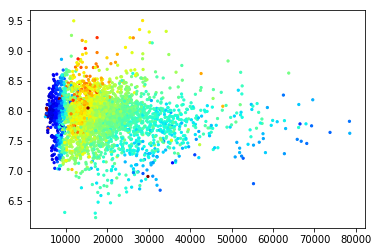

In [4]:
plt.scatter(wdtable['Teff'],wdtable['log_g'], s = 5, c = wdtable['fwhm_b'], vmax = 100, cmap = 'jet')

In [5]:
interpfluxs = [];
lamgrid = np.arange(4000,8000)
for i in tqdm(range(len(wdtable))):
    spec = get_spectrum(wdtable['source_id'][i])
    lam  = spec[0]
    flux = spec[1]
    #trans = ((wdtable['center_b'][i] - hbeta)+(wdtable['center_a'][i]-halpha))/2
    #shiftedflux = interpolation.shift(flux,-trans,cval=np.nan)
    func = interp1d(lam,flux,kind='linear',assume_sorted = False,fill_value='extrapolate')
    interpflux = func(lamgrid)
    interpfluxs.append(interpflux)

100%|██████████| 4155/4155 [02:06<00:00, 32.75it/s]


In [6]:
spectra = np.asarray(interpfluxs)
continuum = pickle.load(open('continuumwls.p','rb'))
lamgrid = np.arange(4000,8000)

In [7]:
def adapted_ch_cont(array,continuum):
    spec = array
    notnan = ~np.isnan(spec)
    p = np.polynomial.chebyshev.chebfit(lamgrid[continuum*notnan],spec[continuum*notnan],5)
    contcorr = spec / np.polynomial.chebyshev.chebval(lamgrid,p)
    return contcorr

In [8]:
def norm_dataspec(array):
    contcorr = adapted_ch_cont(array,continuum)
    skylinemask = (lamgrid > 5578.5 - 10)*(lamgrid < 5578.5 + 10) + (lamgrid > 5894.6 - 10)*(lamgrid < 5894.6 + 10)\
        + (lamgrid > 6301.7 - 10)*(lamgrid < 6301.7 + 10) + (lamgrid > 7246.0 - 10)*(lamgrid < 7246.0 + 10)
    #contcorr[skylinemask] = 1
    #where = np.isnan(contcorr)+(contcorr > 1.25) + (contcorr < 0)
    #contcorr[where] = 1
    return contcorr

In [9]:
wdtable['spectrum'] = interpfluxs

In [10]:
clamgrid = np.linspace(4000,7000,3000)

In [11]:
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize,scale,MinMaxScaler,StandardScaler
import multiprocessing

Using TensorFlow backend.


In [12]:
sc = pickle.load(open('koesterddsc.p','rb'))
msc = pickle.load(open('koesterddmsc.p','rb'))

In [13]:
H = 128
def generator():
    x = Input(shape=(2,))
    y = Dense(H,activation='sigmoid')(x)
    y = Dense(H,activation='sigmoid')(y)
    y = Dense(H,activation='sigmoid')(y)
    y = Dense(H,activation='sigmoid')(y)
    out = Dense(4000,activation='linear')(y)
    
    model = Model(inputs = x, outputs = out)
    model.compile(optimizer = Adamax(), loss = 'mse', \
                  metrics = ['mae'])
    return model
model = generator()
history = [];
model.load_weights('model_interp_deep.h5')
print(model.summary())

W0929 00:38:16.764783 4459537856 deprecation_wrapper.py:119] From /Users/vedantchandra/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0929 00:38:16.780398 4459537856 deprecation_wrapper.py:119] From /Users/vedantchandra/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0929 00:38:16.784260 4459537856 deprecation_wrapper.py:119] From /Users/vedantchandra/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0929 00:38:16.862195 4459537856 deprecation_wrapper.py:119] From /Users/vedantchandra/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instea

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 4000)              516000    
Total params: 565,920
Trainable params: 565,920
Non-trainable params: 0
_________________________________________________________________
None

Text(0.5, 0, 'Wavelength ($\\AA$)')

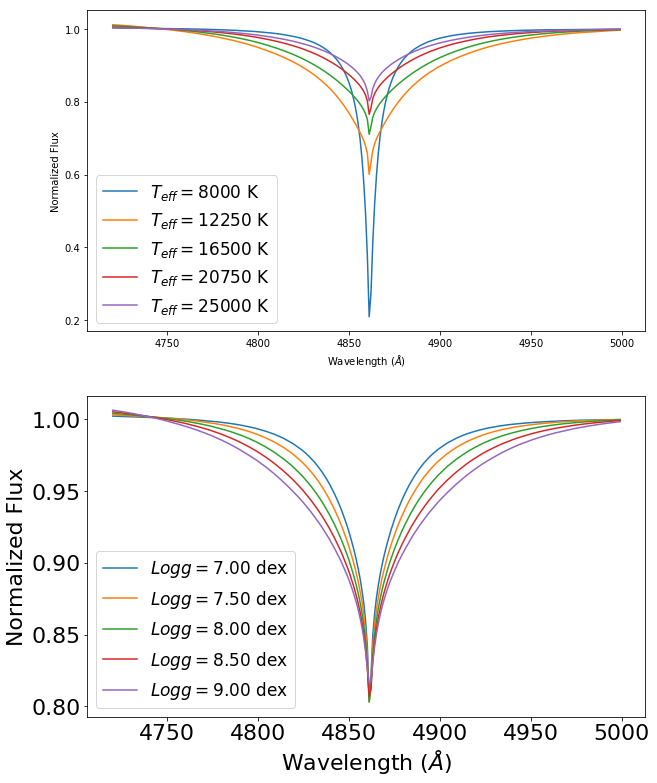

In [14]:
plt.figure(figsize=(10,13))

plt.subplot(211)
ts = np.linspace(8000,25000,5)
ls = np.linspace(8,8,5)
plt.rcParams.update({'font.size': 22})             
samples = sc.transform(np.stack((ts,ls)).transpose())
gens = msc.inverse_transform(model.predict(samples))
tscores = (ts - np.min(ts))/(np.max(ts) - np.min(ts))
for i in range(len(gens)):
    plt.plot(lamgrid[720:1000],norm_dataspec(gens[i])[720:1000],label='$T_{eff} = %i$ K'%ts[i])
plt.legend(fontsize=17)
plt.ylabel('Normalized Flux')
plt.xlabel('Wavelength ($\AA$)')

plt.subplot(212)
ts = np.linspace(25000,25000,5)
ls = np.linspace(7,9,5)
samples = sc.transform(np.stack((ts,ls)).transpose())
gens = msc.inverse_transform(model.predict(samples))
tscores = (ts - np.min(ts))/(np.max(ts) - np.min(ts))
for i in range(len(gens)):
    plt.plot(lamgrid[720:1000],norm_dataspec(gens[i])[720:1000],label='$Logg = %.2f$ dex'%ls[i])
plt.legend(fontsize=17)
plt.ylabel('Normalized Flux')
plt.xlabel('Wavelength ($\AA$)')

# Extract Residuals

In [16]:
lines = ((lamgrid > hbeta-200) & (lamgrid < hbeta + 300)) | ((lamgrid > halpha-250) & (lamgrid < halpha + 300))\
        | ((lamgrid > hgamma-120) & (lamgrid < hgamma + 400))| ((lamgrid > hdelta-90) & (lamgrid < hdelta + 150))

def spectrum_sampler(wl,teff,logg,trans):
    label = sc.transform(np.asarray(np.stack((teff,logg)).reshape(1,-1)))
    synth = dopplerShift(wl,np.ravel(
                        msc.inverse_transform(
                                model.predict(label))[0]
                        ), trans*1000
                    )[0]
    return np.exp(np.ravel(synth).astype('float64'))

def norm_spectrum_sampler(wl,teff,logg,trans):
    synth = spectrum_sampler(lamgrid,teff,logg,trans)
    return adapted_ch_cont(synth,continuum)[lines]

def chisquare(residual):
    return sum(residual**2)

def get_prior_teff(array):
    spec = np.asarray(array)
    priorfitter = lmfit.Model(spectrum_sampler)
    priorparams = priorfitter.make_params()
    priorparams['logg'].set(value = 8., vary = False)
    priorparams['teff'].set(value = 10000,min = 5500, max = 80000)
    priorparams['trans'].set(value = 0., vary = False)
    priorfitter.eval(priorparams, wl = lamgrid)
    prior_result = priorfitter.fit(spec, priorparams, wl = lamgrid, method = 'Powell', nan_policy = 'omit');
    #print(prior_result.fit_report())
    return prior_result.params['teff'].value

def get_posteriors(array):
    spec = array
    normspec = norm_dataspec(spec)
    def chisq(params):
        teff,logg,trans = params
        res = normspec[lines] - norm_spectrum_sampler(lamgrid,teff,logg,trans)
        res = res[~np.isnan(res)]
        chisq = np.sum(res**2)
        return chisq
    teff_init = get_prior_teff(spec)
   # p = scipy.optimize.minimize(chisq, bounds = [(5500,80000),(6.5,9.5),(-3,3)], x0 = [teff_init, 8., 0],\
                             #  method = 'dual_annealing')
    try:
        p = scipy.optimize.dual_annealing(chisq,bounds = [(5600,80000),(6.5,9.5),(-3,3)],maxfun = 100,\
                                      x0 = [teff_init, 8., 0])
    except:
        print('fitting error')
        return np.asarray([teff_init,8.,0])
    #p = scipy.optimize.differential_evolution(chisq,bounds = [(5500,80000),(6.5,9.5),(-3,3)],\
       #                              disp = True)
    
#     plt.plot(normspec[lines])
#     plt.plot(norm_spectrum_sampler(lamgrid,p.x[0],p.x[1],p.x[2]))
    return p.x

In [18]:
resids = [];
sampleteffs = [];
sampleloggs = [];
for ii in tqdm(range(len(wdtable[0:4000]))):
    fitlabel = get_posteriors(wdtable[ii]['spectrum'])
    teff = fitlabel[0]
    logg = fitlabel[1]
    trans = fitlabel[2]
    sampleteffs.append(teff)
    sampleloggs.append(logg)
    pred = adapted_ch_cont(spectrum_sampler(lamgrid,teff,logg,trans),continuum)
    true = norm_dataspec(wdtable[ii]['spectrum'])
    
    resids.append(true-pred)
    
#     plt.figure()
#     plt.plot(true)
#     plt.plot(pred)
    
resids = np.asarray(resids)
sampleteffs = np.asarray(sampleteffs)
sampleloggs = np.asarray(sampleloggs)


  4%|▍         | 152/4000 [01:01<22:00,  2.91it/s]


  8%|▊         | 303/4000 [02:03<26:30,  2.32it/s]


 11%|█▏        | 454/4000 [03:04<20:15,  2.92it/s]


 15%|█▌        | 605/4000 [04:09<19:51,  2.85it/s]


 19%|█▉        | 756/4000 [05:11<20:25,  2.65it/s]


 23%|██▎       | 907/4000 [06:10<23:07,  2.23it/s]


 26%|██▋       | 1057/4000 [07:05<16:55,  2.90it/s]


 30%|███       | 1205/4000 [08:01<21:23,  2.18it/s]


 34%|███▍      | 1353/4000 [09:02<17:12,  2.56it/s]


 38%|███▊      | 1501/4000 [09:58<17:37,  2.36it/s]


 41%|████      | 1649/4000 [10:56<13:06,  2.99it/s]


 44%|████▍     | 1753/4000 [11:37<33:53,  1.11it/s]

fitting error



 48%|████▊     | 1901/4000 [12:35<10:58,  3.19it/s]


 51%|█████     | 2049/4000 [13:31<09:53,  3.29it/s]


 55%|█████▍    | 2197/4000 [14:24<09:18,  3.23it/s]


 59%|█████▊    | 2345/4000 [15:19<09:36,  2.87it/s]


 62%|██████▏   | 2493/4000 [16:14<08:27,  2.97it/s]


 66%|██████▌   | 2641/4000 [17:08<08:32,  2.65it/s]


 70%|██████▉   | 2789/4000 [18:01<07:16,  2.78it/s]


 73%|███████▎  | 2937/4000 [18:54<06:43,  2.64it/s]


 77%|███████▋  | 3085/4000 [19:42<05:13,  2.92it/s]


 81%|████████  | 3233/4000 [20:37<04:51,  2.63it/s]


 85%|████████▍ | 3381/4000 [21:31<03:06,  3.31it/s]


 88%|████████▊ | 3529/4000 [22:28<02:53,  2.71it/s]


 92%|█████████▏| 3677/4000 [23:27<01:49,  2.94it/s]


 96%|█████████▌| 3825/4000 [24:27<00:53,  3.29it/s]


 99%|█████████▉| 3973/4000 [25:24<00:08,  3.20it/s]


100%|██████████| 4000/4000 [25:34<00:00,  3.38it/s]

In [19]:
spectrum_sampler(lamgrid,15000,8,-3)

array([28.55751663, 28.51140284, 28.45991547, ...,         nan,
               nan,         nan])

In [20]:
resids[np.isnan(resids)] = 0

In [123]:
bound = 10
linecore = 5893 # mg Line
lower = linecore - 4000 - bound
upper = linecore - 4000 + bound
linewl = lamgrid[lower:upper]

In [124]:
core_residuals = resids[:,lower:upper]

In [125]:
lineflags = np.repeat(0,len(core_residuals))
max_peaks = [];
for i in range(len(core_residuals)):
    mean = np.mean(core_residuals[i])
    std = np.std(core_residuals[i])
    zscore = (core_residuals[i] - mean)/std
    max_peaks.append(np.max(np.abs(core_residuals[i])))
    if sum(zscore < -3) > 0:
        lineflags[i] = 1

lineflags = lineflags.astype(bool)
max_peaks = np.asarray(max_peaks)

Text(0.5, 0, 'Wavelength ($\\AA$)')

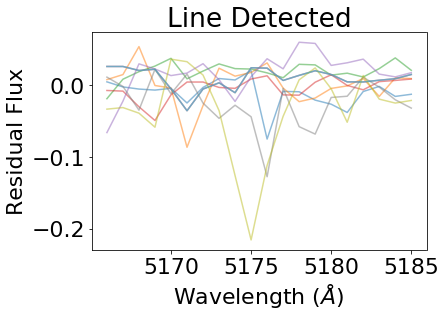

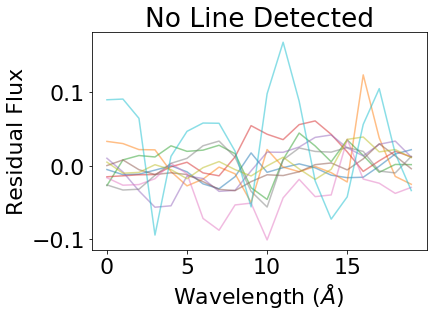

In [173]:
samples = 10
plt.plot(linewl,core_residuals[lineflags][np.random.randint(0,len(core_residuals[lineflags]),samples)].T, alpha = 0.5);
plt.title('Line Detected')
plt.ylabel('Residual Flux')
plt.xlabel('Wavelength ($\AA$)')

plt.figure()
plt.plot(core_residuals[~lineflags][np.random.randint(0,len(core_residuals[~lineflags]),samples)].T, alpha = 0.5);
plt.title('No Line Detected')
plt.ylabel('Residual Flux')
plt.xlabel('Wavelength ($\AA$)')

In [312]:
def fit_mg_triplet(residual):
    
    mg1 = 5167
    mg2 = 5172
    mg3 = 5184

    gauss1 = lmfit.models.GaussianModel(prefix = 'g1_')
    params = gauss1.make_params()
    params['g1_center'].set(value = mg1, min = mg1 - 15, max = mg1 + 15)
    
    gauss2 = lmfit.models.GaussianModel(prefix = 'g2_')
    params.update(gauss2.make_params())
    params['g2_center'].set(value = mg2, min = mg2 - 15, max = mg2 + 15)
    
    gauss3 = lmfit.models.GaussianModel(prefix = 'g3_')
    params.update(gauss3.make_params())
    params['g3_center'].set(value = mg3, min = mg3 - 15, max = mg3 + 15)
    
    model = gauss1 + gauss2 + gauss3
    
    res = model.fit(residual, params, x = lamgrid)
    return res

In [326]:
def fit_mg_triplet(residual):
    
    mg1 = 4307

    gauss1 = lmfit.models.GaussianModel(prefix = 'g1_')
    params = gauss1.make_params()
    params['g1_center'].set(value = mg1, min = mg1 - 15, max = mg1 + 15)
    
    model = gauss1
    
    res = model.fit(residual, params, x = lamgrid)
    return res

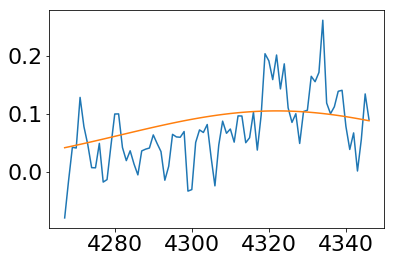

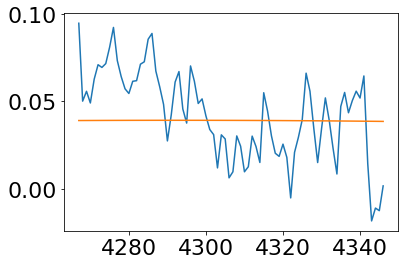

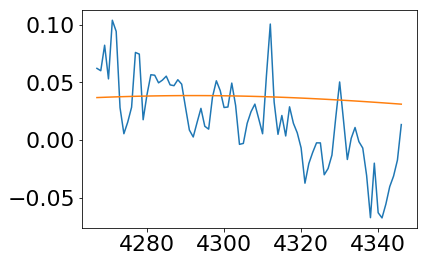

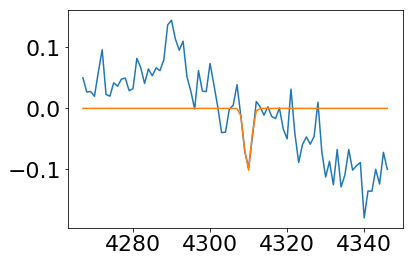

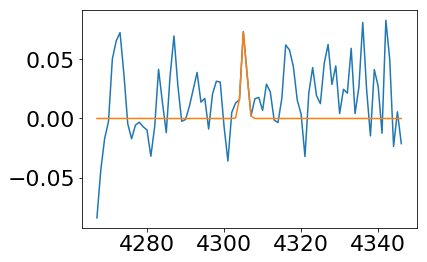

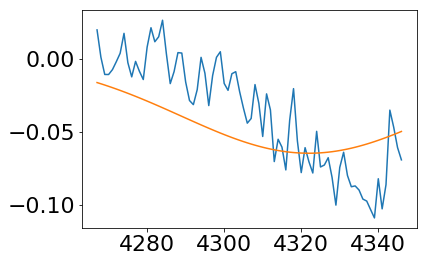

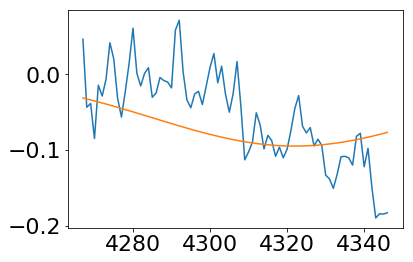

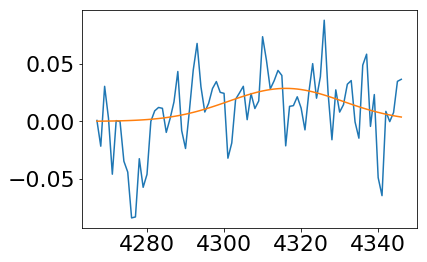

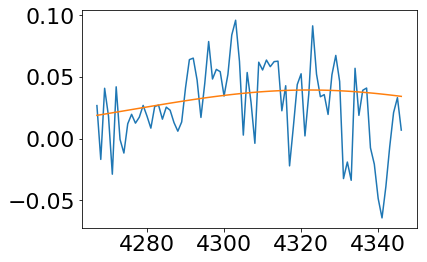

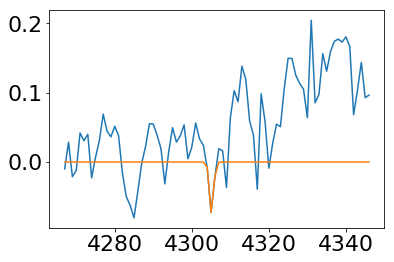

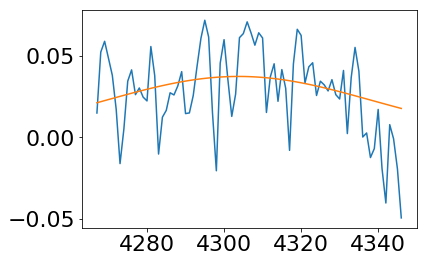

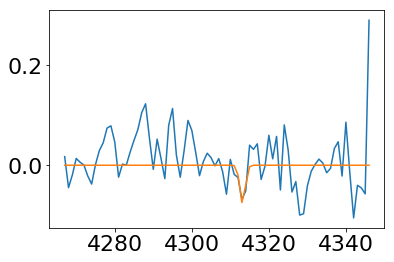

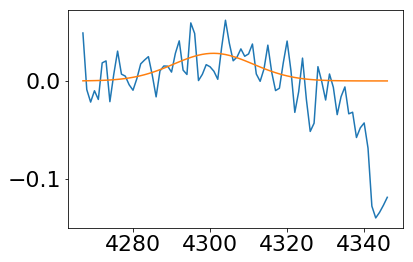

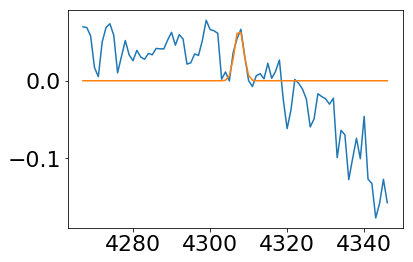

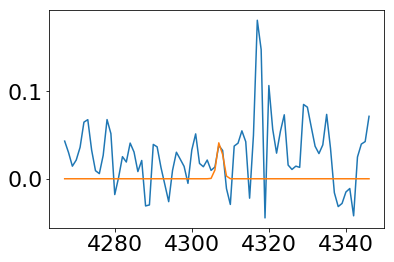

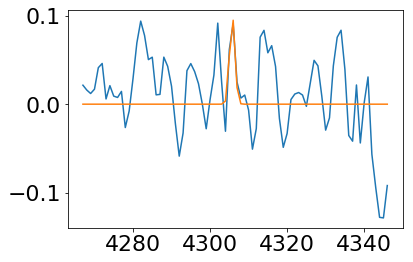

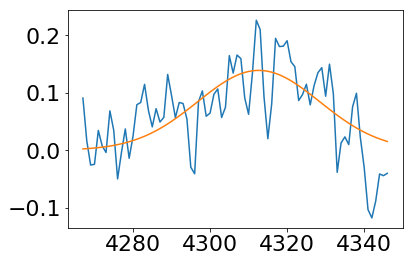

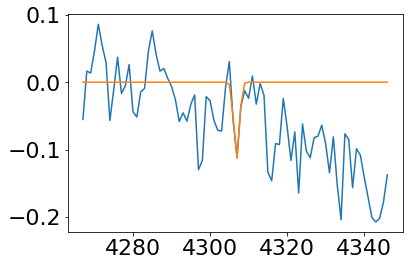

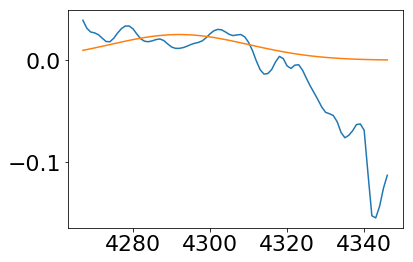

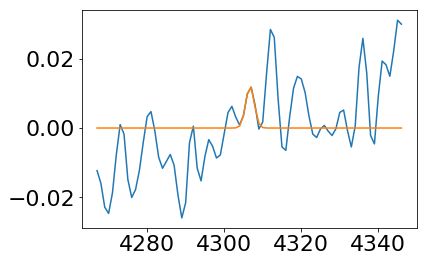

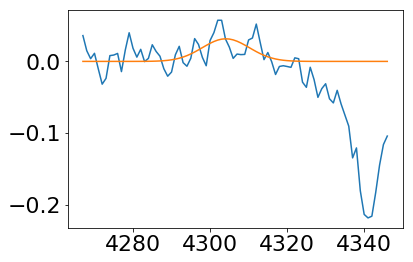

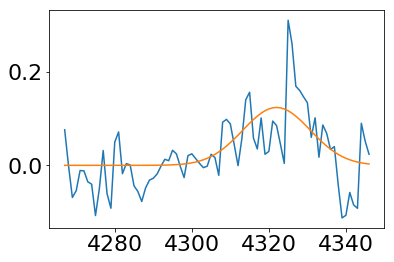

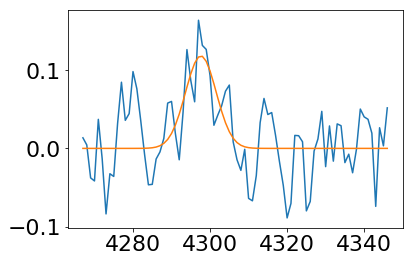

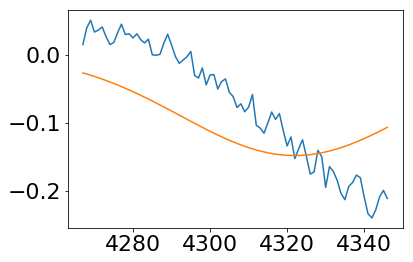

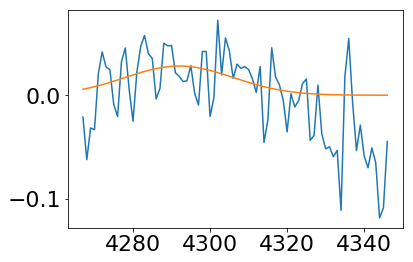

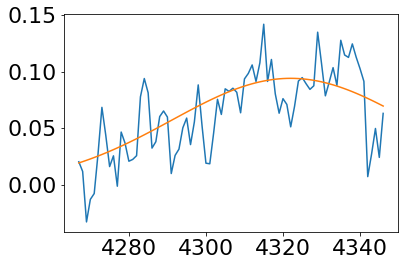

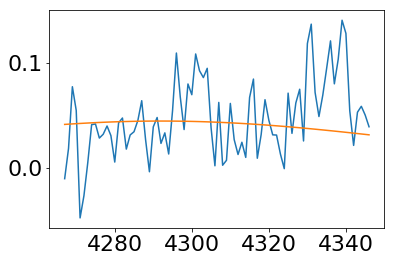

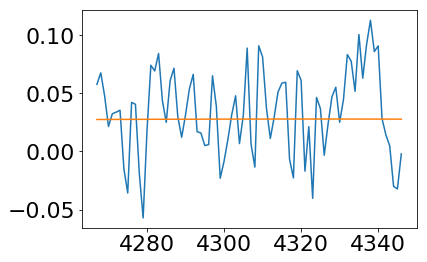

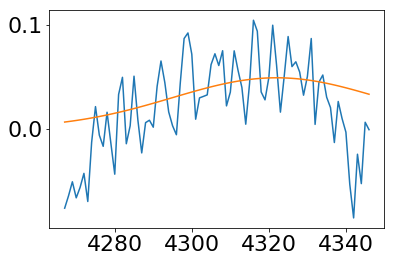

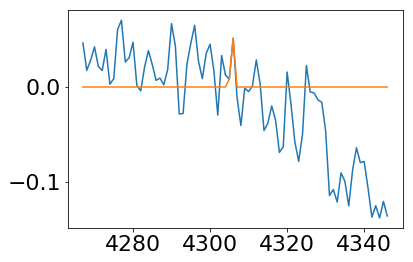

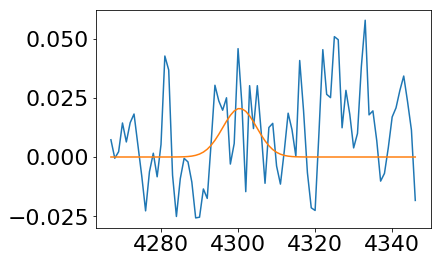

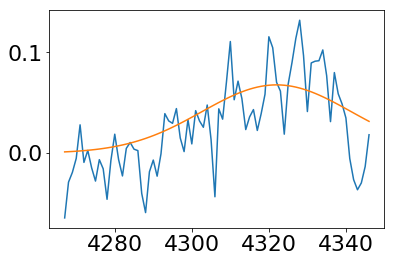

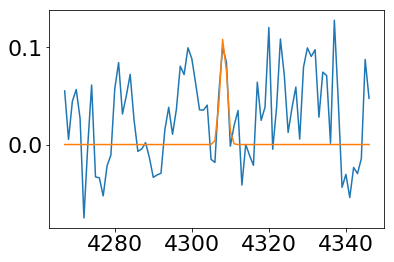

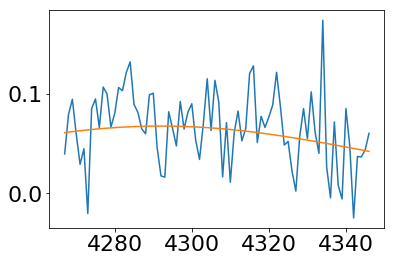

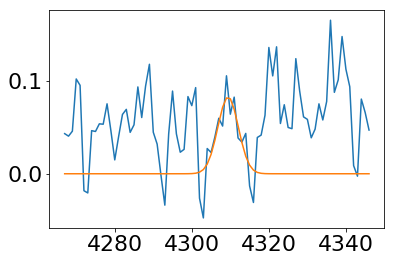

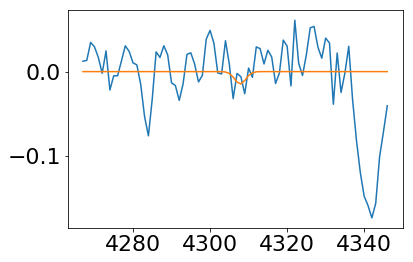

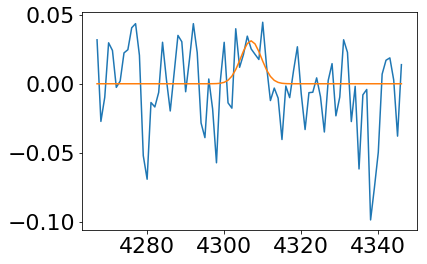

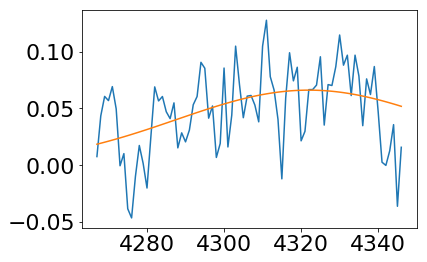

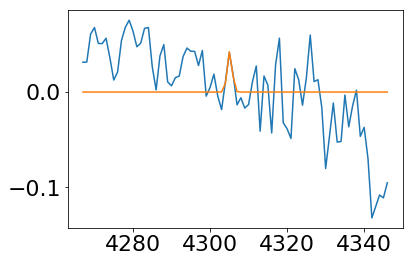

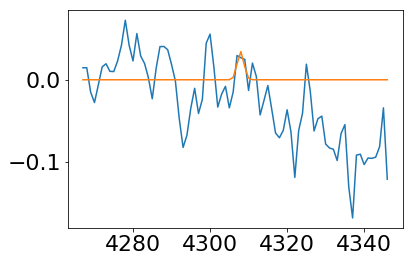

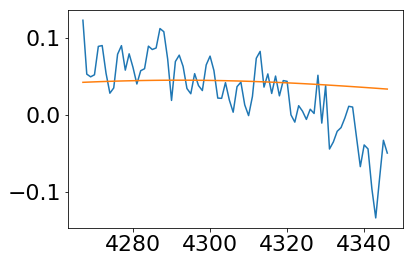

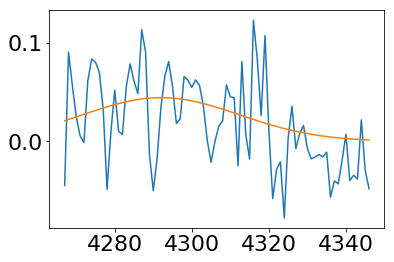

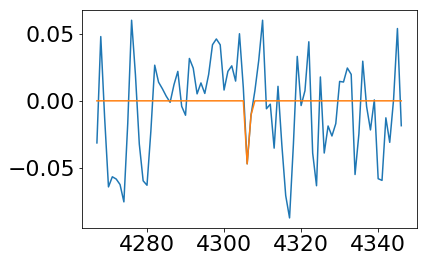

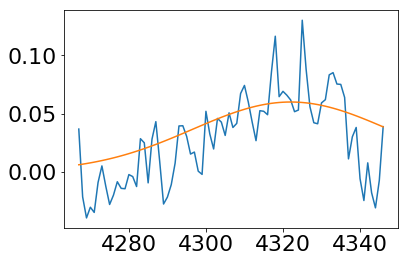

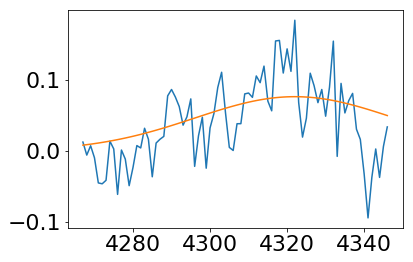

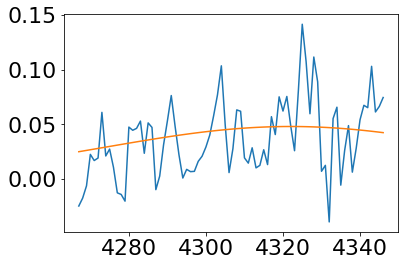

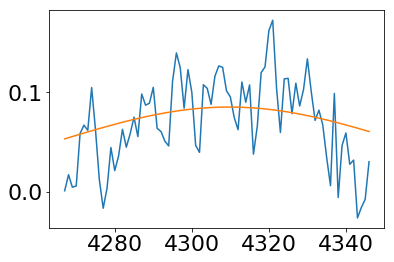

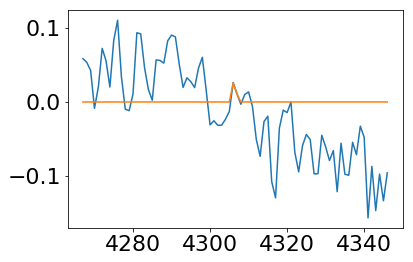

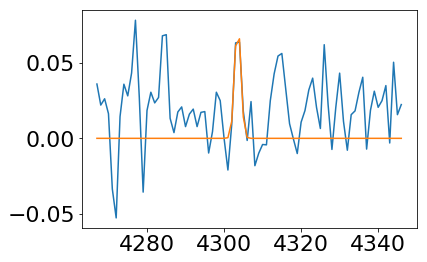

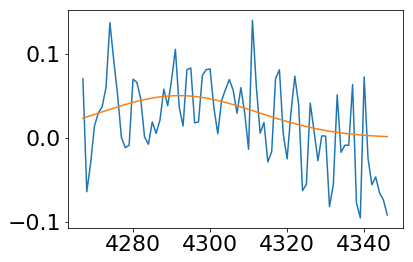

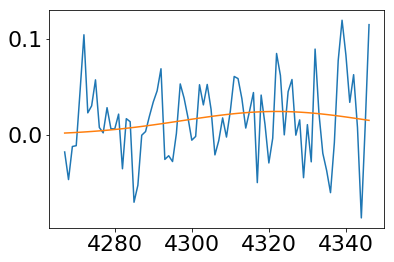

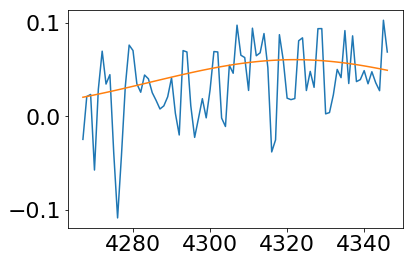

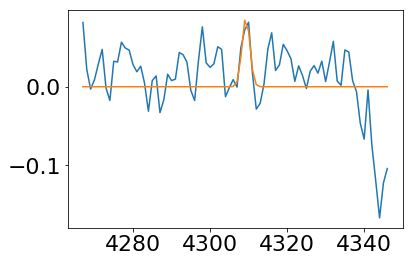

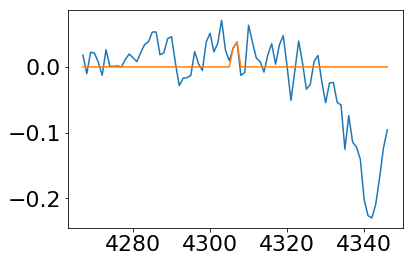

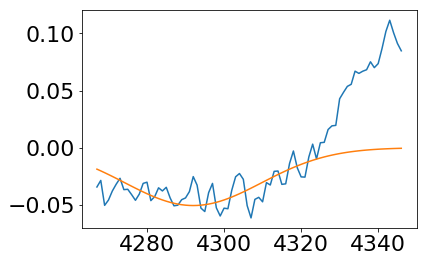

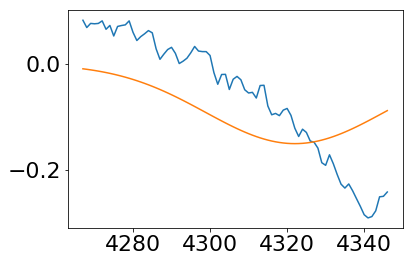

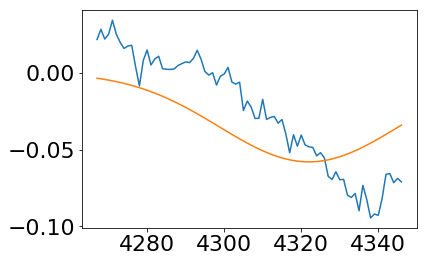

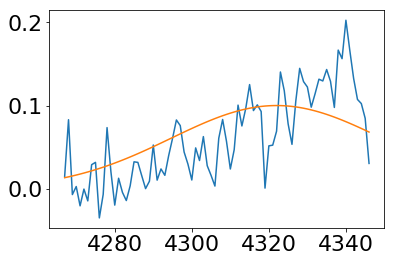

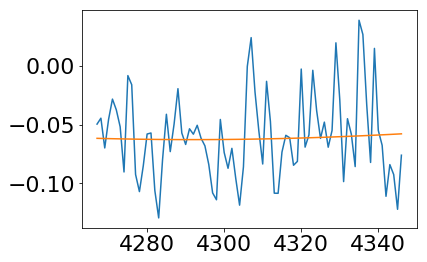

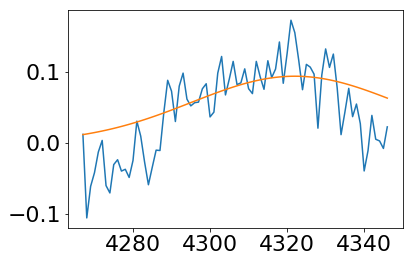

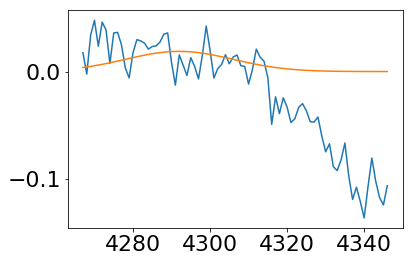

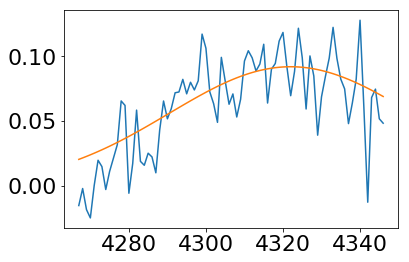

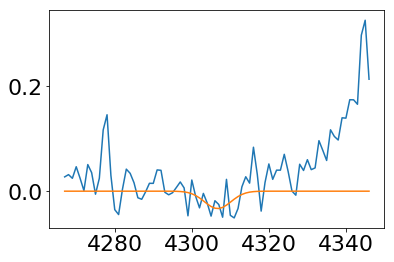

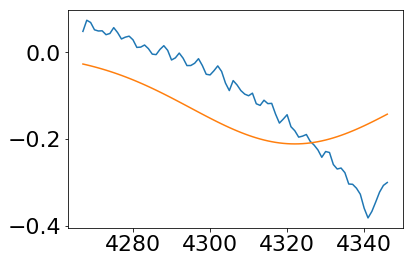

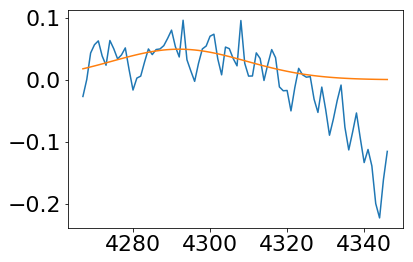

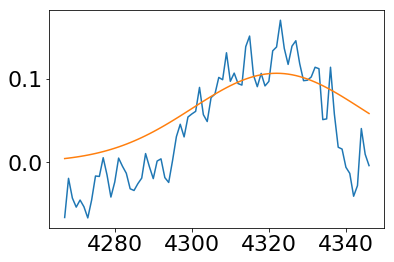

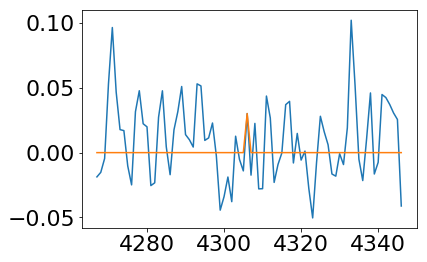

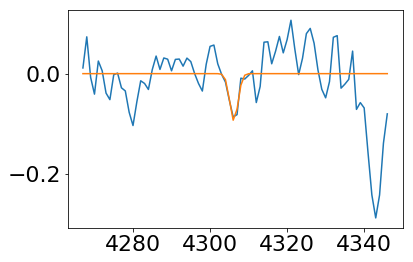

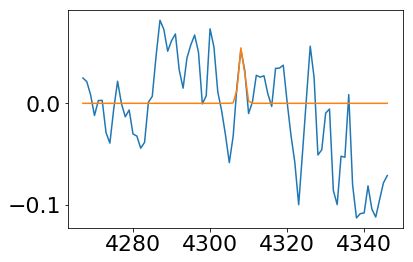

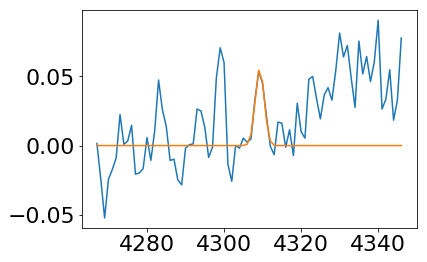

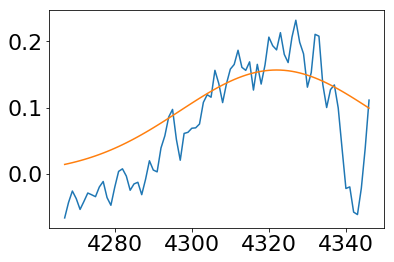

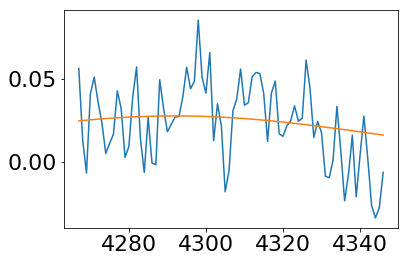

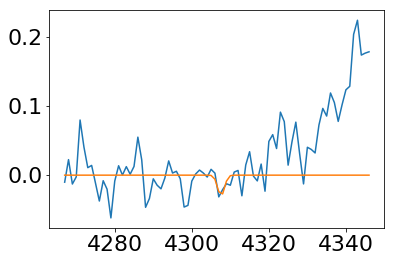

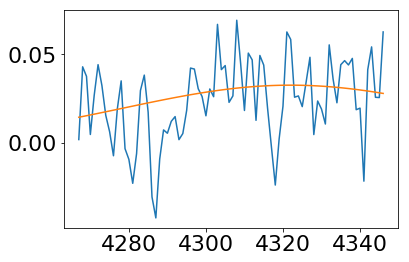

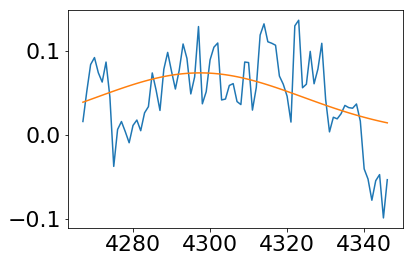

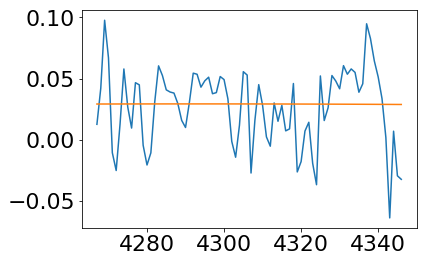

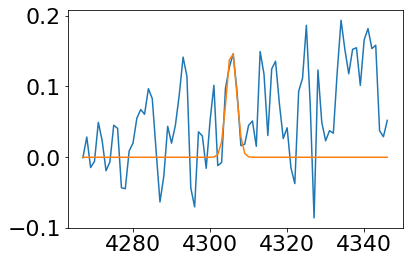

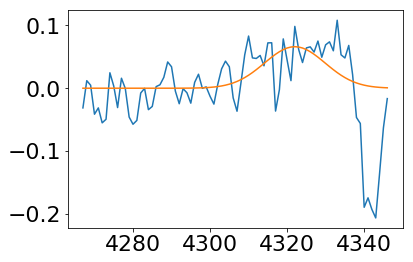

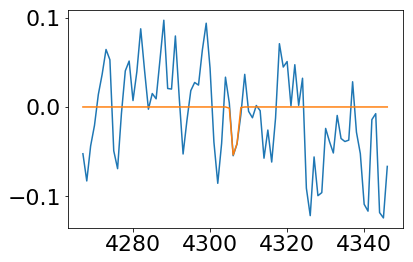

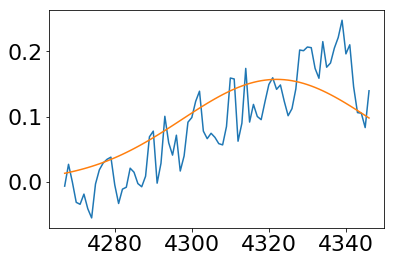

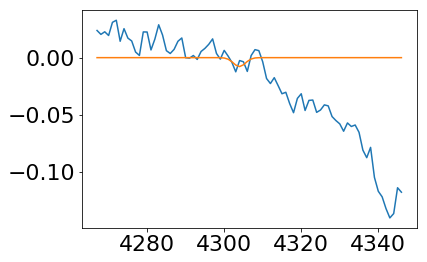

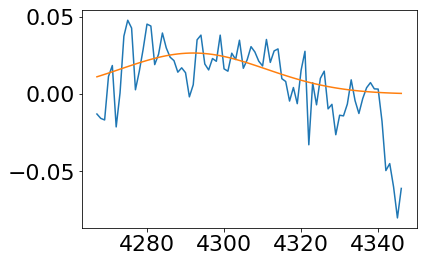

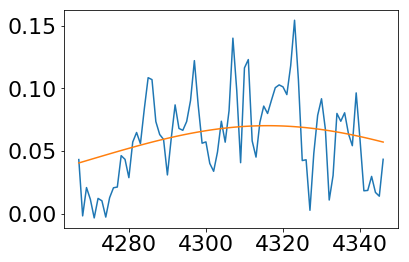

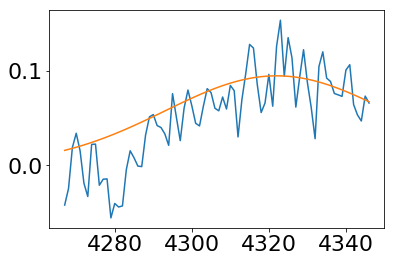

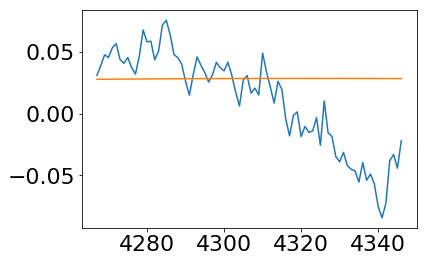

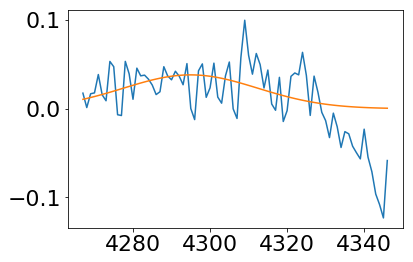

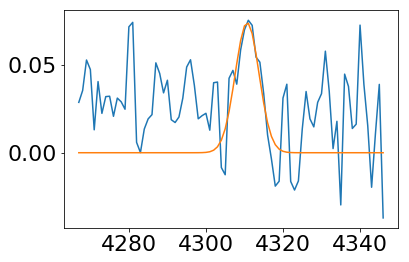

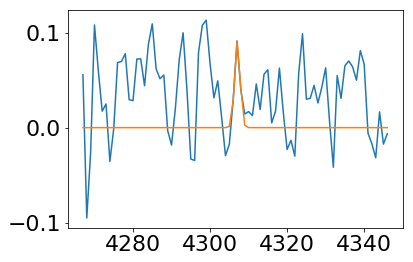

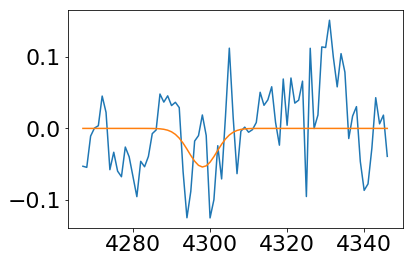

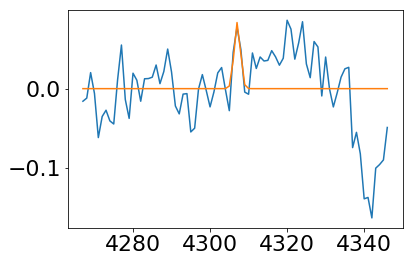

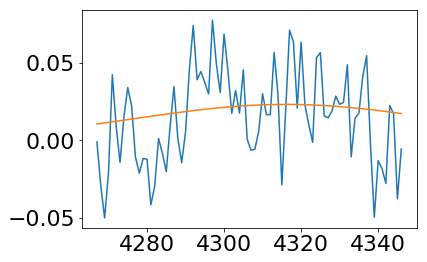

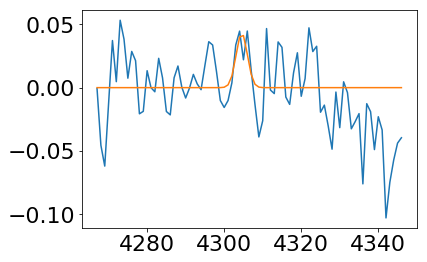

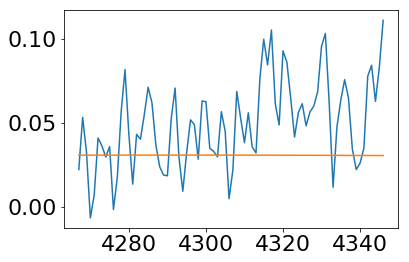

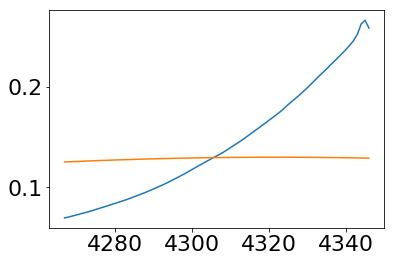

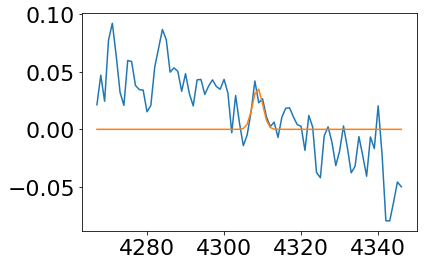

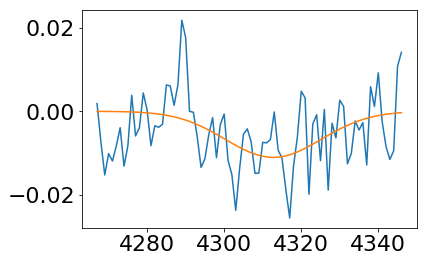

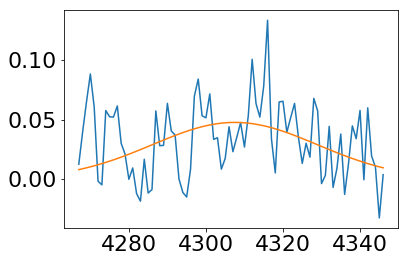

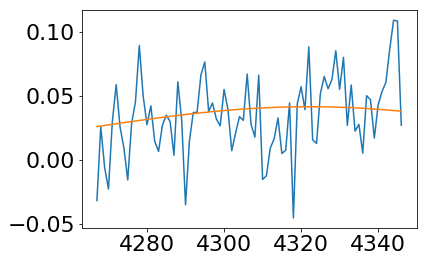

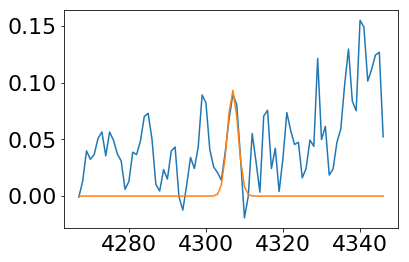

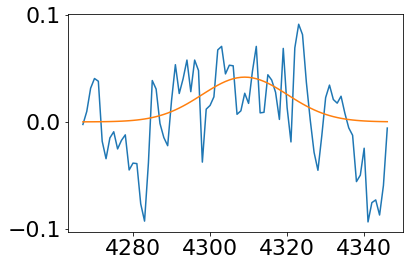

In [331]:
linecore = 4307 # mg Line
lower = linecore - 4000 - 40
upper = linecore - 4000 + 40
amps = [];
for ii in range(len(resids[0:100])):
    result = fit_mg_triplet(resids[ii])
    plt.plot(lamgrid[lower:upper],resids[ii][lower:upper])
    plt.plot(lamgrid[lower:upper],result.eval(result.params, x = lamgrid)[lower:upper])
    plt.show()
    amps.append(result.params['g1_amplitude'])

In [328]:
ampvalues = np.asarray([i.value for i in amps])

In [329]:
candidates = ampvalues < -3

(array([1.000e+00, 0.000e+00, 1.240e+02, 3.869e+03, 5.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-218.55448188, -148.00783184,  -77.4611818 ,   -6.91453176,
          63.63211828,  134.17876832,  204.72541836,  275.27206839,
         345.81871843,  416.36536847,  486.91201851]),
 <a list of 10 Patch objects>)

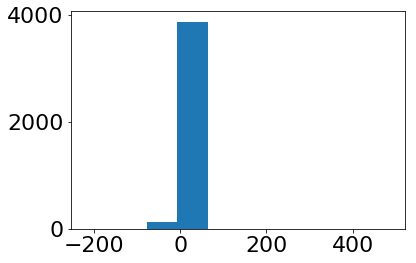

In [335]:
plt.hist(ampvalues)